In [8]:
%matplotlib inline
import matplotlib.pylab as plt
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import pickle

from pruner import * 
from models import *
from norbloader import *

In [9]:
device = 'cuda:0'
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE=512

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./cifar-data', train=True,
                                     download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE,
                                         shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar-data', train=False,
                                     download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE,
                                         shuffle=False, num_workers=4)
# trainset = NORB(root='./norb-data/', transform=transform_train, train=True)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE,
#                                          shuffle=True, num_workers=2)

# testset = NORB(root='./norb-data/', transform=transform_test, train=False)
# testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE,
#                                          shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
net = ResNet18(trainloader, testloader, device=device)
net.param_count()
# net = net.to(device)

11169161.0

In [12]:
net = VGG('VGG19',trainloader, testloader, device=device)
net.param_count()
# net = net.to(device)

20035017.0

In [17]:
net.load_state_dict(torch.load('./checkpoints/iterative-pruning-cifar10/test-all-2-init'))
pruner_save = pickle.load(open('./experiment_data/iterative-pruning-cifar10/test-all-2-6.p', 'rb'))
pruner = SparsityPruner(net)
pruner.masks = pruner_save.masks
pruner.apply_mask(prune_global=True)
net.test()

(0.19775390625, 2.3033175816138587)

# TODO: TL + LATE RESETTING

In [18]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
N_EPOCH=50
LOG=100

def get_lr(epoch):
    if (epoch+1) >= 150:
        return 1e-4
    elif (epoch+1) >= 100:
        return 5e-3
    return 1e-3

for epoch in range(N_EPOCH):
    print('Starting epoch {}'.format(epoch+1))
    optimizer = optim.SGD(net.parameters(), lr=get_lr(epoch), momentum=0.9, weight_decay=1e-4)
    plt_data = (train_losses, val_losses, train_accs, val_accs)
    train_losses, val_losses, train_accs, val_accs, stopped = net.train_epoch(epoch,
        optimizer, plot=True, data=plt_data, LOG=LOG)
    if stopped:
        break

Starting epoch 1
[epoch:1,batch:100]: loss(train): 1.269, acc(train): 0.750, loss(val): 1.055, acc(val): 0.570
Starting epoch 2
[epoch:2,batch:100]: loss(train): 0.978, acc(train): 0.820, loss(val): 1.328, acc(val): 0.532
Starting epoch 3
[epoch:3,batch:100]: loss(train): 1.207, acc(train): 0.664, loss(val): 1.072, acc(val): 0.578
Starting epoch 4


KeyboardInterrupt: 

In [66]:
net.param_count()

8941937.0

In [67]:
net.test()

(0.8496907552083334, 1.2844280811647575)

In [68]:
save_data = {'train_losses': train_losses, 
            'val_losses': val_losses, 
            'train_accs': train_accs, 
            'val_accs': val_accs}
pd.DataFrame(save_data).to_csv('./experiment_data/iterative-pruning-cifar10/norb-transfer-1.csv')

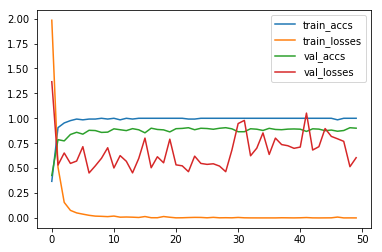

In [63]:
pd.DataFrame(save_data).plot()

In [3]:
TRAIN_BATCH_SIZE=128
TEST_BATCH_SIZE=100

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_tr = torchvision.datasets.FashionMNIST(root='./fashion-mnist', train=True,
                                        download=True, transform=transform_train)
trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=TRAIN_BATCH_SIZE,
                                        shuffle=True, num_workers=2)  

testset_tr = torchvision.datasets.FashionMNIST(root='./fashion-mnist', train=False,
                                        download=True, transform=transform_train)
testloader_tr = torch.utils.data.DataLoader(testset_tr, batch_size=TEST_BATCH_SIZE,
                                        shuffle=False, num_workers=2)  

In [18]:
x[0].shape

torch.Size([100, 1, 32, 32])

In [29]:
trainloader_tr.dataset.__str__().split('\n')[0]

'Dataset FashionMNIST'

In [30]:
trainloader_tr.batch_size

128

In [4]:
net = ResNet18(trainloader_tr, testloader_tr, device='cuda:0')
net = net.to('cuda:0')

In [5]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01,momentum=0.9)
net.train_epoch(0, optimizer, plot=True, LOG=10)

[epoch:1,batch:10]: loss(train): 2.041, acc(train): 0.430, loss(val): 2.308, acc(val): 0.100
[epoch:1,batch:20]: loss(train): 2.301, acc(train): 0.195, loss(val): 2.299, acc(val): 0.119
[epoch:1,batch:30]: loss(train): 2.292, acc(train): 0.031, loss(val): 2.266, acc(val): 0.126
[epoch:1,batch:40]: loss(train): 2.212, acc(train): 0.359, loss(val): 2.105, acc(val): 0.224
[epoch:1,batch:50]: loss(train): 1.948, acc(train): 0.211, loss(val): 1.823, acc(val): 0.227
[epoch:1,batch:60]: loss(train): 1.729, acc(train): 0.297, loss(val): 1.688, acc(val): 0.330
[epoch:1,batch:70]: loss(train): 1.635, acc(train): 0.312, loss(val): 1.524, acc(val): 0.378
[epoch:1,batch:80]: loss(train): 1.556, acc(train): 0.281, loss(val): 1.500, acc(val): 0.345
[epoch:1,batch:90]: loss(train): 1.508, acc(train): 0.336, loss(val): 1.483, acc(val): 0.342
[epoch:1,batch:100]: loss(train): 1.449, acc(train): 0.492, loss(val): 1.409, acc(val): 0.406
[epoch:1,batch:110]: loss(train): 1.520, acc(train): 0.391, loss(val)

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size]

KeyboardInterrupt: 

In [6]:
net.test()

(0.5114, 1.2257155406475067)